#### Importo las librerias necesarias

In [204]:
import numpy as np                         
import pandas as pd                         
import matplotlib.pyplot as plt        
import seaborn as sns   
import gc

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor

from xgboost import XGBRegressor

### Parte A - Transformacion de Datos

In [2]:
data = pd.read_csv('DS_Proyecto_01_Datos_Properati.csv')   # Leo el DataFrame de propiedades Properati
#data.head()    

In [3]:
print('Filas y Columnas:')
data.shape  

Filas y Columnas:


(146660, 19)

In [4]:
data.columns 

Index(['start_date', 'end_date', 'created_on', 'lat', 'lon', 'l1', 'l2', 'l3',
       'rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered',
       'price', 'currency', 'title', 'description', 'property_type',
       'operation_type'],
      dtype='object')

#### Evaluacion e Imputacion de Nulos 

In [5]:
#Evaluo los nulos 
data.isna().sum()/len(data) * 100

start_date          0.000000
end_date            0.000000
created_on          0.000000
lat                 6.767353
lon                 6.790536
l1                  0.000000
l2                  0.000000
l3                  0.000000
rooms               0.000000
bedrooms            0.000000
bathrooms           4.061776
surface_total      13.996318
surface_covered    14.737488
price               0.000000
currency            0.000000
title               0.000000
description         0.000000
property_type       0.000000
operation_type      0.000000
dtype: float64

##### Lo primero que observo es que tengo valores nulos en 'lat' y 'lon', algo que no voy a necesitar en este analisis, en bathrooms voy a implementar una imputacion y en surface_total y surface_covered primero me aseguro que la cubierta no supere a la total.

In [6]:
#Elimino las columnas innesesarias
columnas_descartables = ['start_date','end_date','created_on','lat','lon','currency','operation_type','description','title']
data = data.drop(columnas_descartables,1)

In [7]:
data.shape

(146660, 10)

In [8]:
#Realizo una mascara para eliminar los valores de superfice cubierta mayores a superficie total
mask = data.surface_total >= data.surface_covered
data = data[mask]
#data.head()

In [9]:
#Vuelvo a evaluar los nulos 
data.isna().sum()/len(data) * 100

l1                 0.000000
l2                 0.000000
l3                 0.000000
rooms              0.000000
bedrooms           0.000000
bathrooms          1.379378
surface_total      0.000000
surface_covered    0.000000
price              0.000000
property_type      0.000000
dtype: float64

##### Observando que ya solo poseo nulos en bathrooms, realizo una imputacion con la media. 

In [10]:
#Elijo una imputacion simple para bathrooms
imp_mean = SimpleImputer(strategy='most_frequent')

In [11]:
data[['bathrooms']] = imp_mean.fit_transform(data[['bathrooms']])

In [12]:
#Vuelvo a evaluar los nulos 
data.isna().sum()/len(data) * 100

l1                 0.0
l2                 0.0
l3                 0.0
rooms              0.0
bedrooms           0.0
bathrooms          0.0
surface_total      0.0
surface_covered    0.0
price              0.0
property_type      0.0
dtype: float64

In [13]:
print('Filas y Columnas:')
data.shape  

Filas y Columnas:


(123099, 10)

### Outliers

D:\Programas\Ananconda\envs\datascience\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
D:\Programas\Ananconda\envs\datascience\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


<Figure size 1080x432 with 0 Axes>

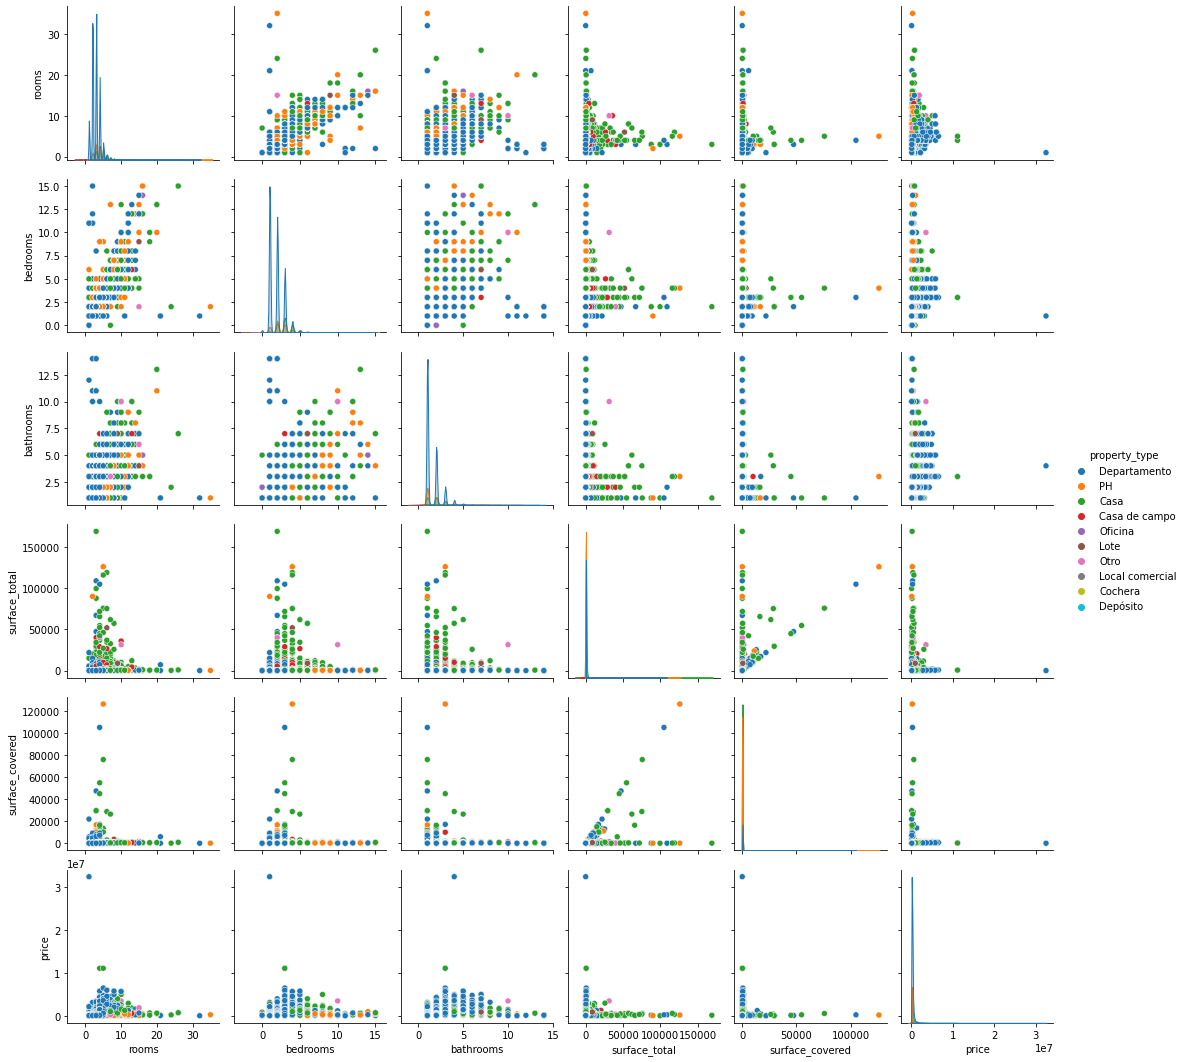

In [14]:
plt.figure(figsize=(15,6))
sns.pairplot(data,hue='property_type')
plt.show()

##### Observando el grafico podemos ver la gran cantidad de Outliers que hay en el dataset, voy a enfocarme en las columnas rooms, bedrooms, bathrooms, surface_total, surface_covered y price.

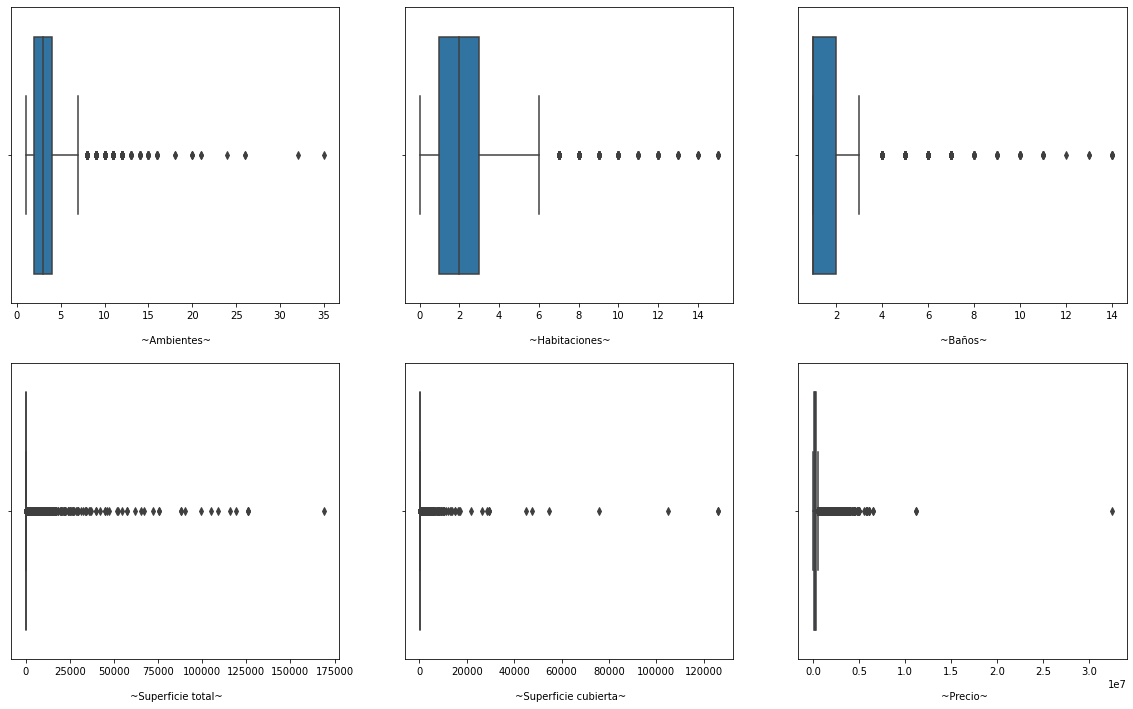

In [15]:
plt.figure(figsize=(20,12))
plt.subplot(2,3,1)
sns.boxplot(data = data, x = 'rooms')                 
plt.xlabel('\n ~Ambientes~') 

plt.subplot(2,3,2)
sns.boxplot(data = data, x = 'bedrooms')   
plt.xlabel('\n ~Habitaciones~') 

plt.subplot(2,3,3)
sns.boxplot(data = data, x = 'bathrooms')    
plt.xlabel('\n ~Baños~') 

plt.subplot(2,3,4)
sns.boxplot(data = data, x = 'surface_total') 
plt.xlabel('\n ~Superficie total~') 

plt.subplot(2,3,5)
sns.boxplot(data = data, x = 'surface_covered') 
plt.xlabel('\n ~Superficie cubierta~') 

plt.subplot(2,3,6)
sns.boxplot(data = data, x = 'price')          
plt.xlabel('\n ~Precio~') 
plt.show()

##### Observamos claramente como los Outliers aparecen en los Boxplots. Procedo a utilizar la regla de las Tres sigmas y Rango intercualico para ver cual se ajusta mas a mi analisis.

In [16]:
columns = { 'rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered', 'price'}

### Regla de las Tres Sigmas 

In [17]:
def remove_outliers_TS(df, column_name, sigma):
    valor_medio = df[column_name].mean()
    std = df[column_name].std()
    minimo = valor_medio - sigma*std
    maximo = valor_medio + sigma*std
    mascara_outliers = np.logical_or(df[column_name] < minimo, df[column_name] > maximo)
    print(mascara_outliers.sum() / len(mascara_outliers) * 100)
    df = df[~mascara_outliers]
    return df

In [18]:
data_TS = data.copy()
sigma = 3
for i in columns:
    data_TS = remove_outliers_TS(data_TS,i,sigma)

0.29488460507396486
1.7916503715291359
0.8171764686361864
2.4524892933618845
0.6405419310581375
0.7931096976862599


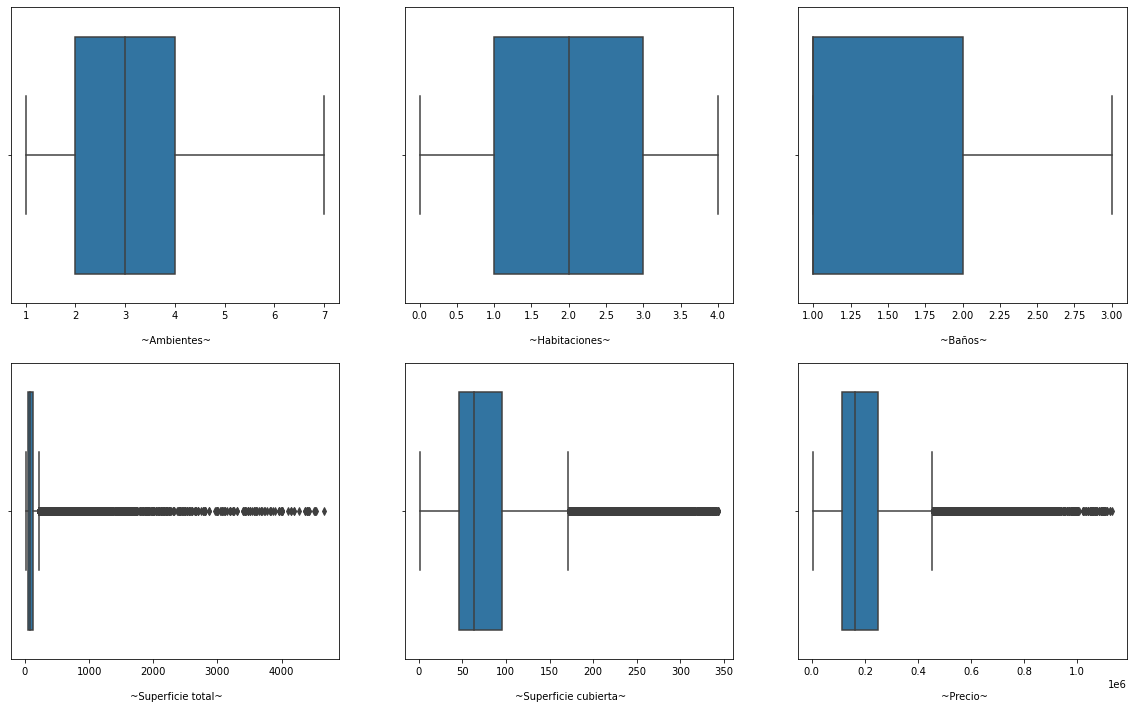

In [19]:
plt.figure(figsize=(20,12))
plt.subplot(2,3,1)
sns.boxplot(data = data_TS, x = 'rooms')                 
plt.xlabel('\n ~Ambientes~') 

plt.subplot(2,3,2)
sns.boxplot(data = data_TS, x = 'bedrooms')   
plt.xlabel('\n ~Habitaciones~') 

plt.subplot(2,3,3)
sns.boxplot(data = data_TS, x = 'bathrooms')    
plt.xlabel('\n ~Baños~') 

plt.subplot(2,3,4)
sns.boxplot(data = data_TS, x = 'surface_total') 
plt.xlabel('\n ~Superficie total~') 

plt.subplot(2,3,5)
sns.boxplot(data = data_TS, x = 'surface_covered') 
plt.xlabel('\n ~Superficie cubierta~') 

plt.subplot(2,3,6)
sns.boxplot(data = data_TS, x = 'price')          
plt.xlabel('\n ~Precio~') 
plt.show()

#### Al aplicar la regla de las Tres Sigmas eliminamos menos del 2.3% de Outliers en cada columna.

### Rango Intercuartilico 

In [20]:
def remove_outliers_RI(df, column_name):
    q25 = np.percentile(df[column_name],25)
    q75 = np.percentile(df[column_name],75)
    iqr = q75 - q25
    minimo = q25 - 1.5 * iqr
    maximo = q75 + 1.5 * iqr
    mascara_outliers = np.logical_or(df[column_name] < minimo, df[column_name] > maximo)
    print(mascara_outliers.sum() / len(mascara_outliers) * 100)
    df = df[~mascara_outliers]
    return df

In [21]:
data_RI = data.copy()
for k in columns:
    data_RI = remove_outliers_RI(data_RI,k)

10.472871428687478
6.5004945239413106
5.65977310443213
0.4947999711966753
3.2089320789827354
0.10360369982697114


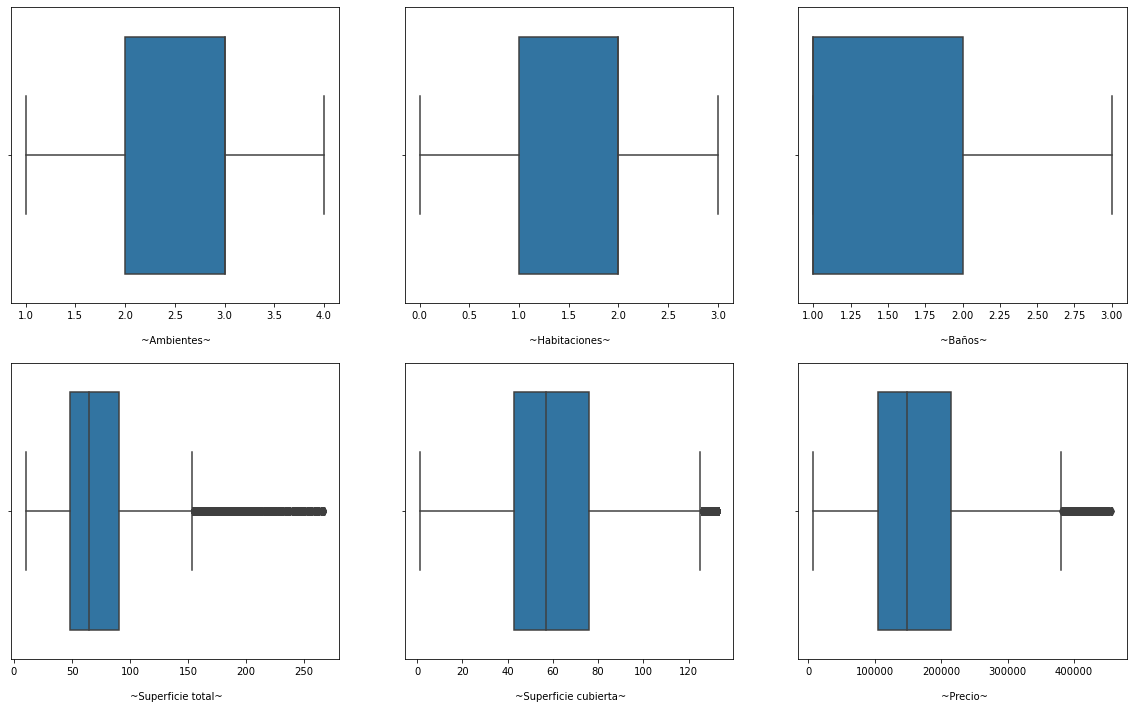

In [22]:
plt.figure(figsize=(20,12))
plt.subplot(2,3,1)
sns.boxplot(data = data_RI, x = 'rooms')                 
plt.xlabel('\n ~Ambientes~') 

plt.subplot(2,3,2)
sns.boxplot(data = data_RI, x = 'bedrooms')   
plt.xlabel('\n ~Habitaciones~') 

plt.subplot(2,3,3)
sns.boxplot(data = data_RI, x = 'bathrooms')    
plt.xlabel('\n ~Baños~') 

plt.subplot(2,3,4)
sns.boxplot(data = data_RI, x = 'surface_total') 
plt.xlabel('\n ~Superficie total~') 

plt.subplot(2,3,5)
sns.boxplot(data = data_RI, x = 'surface_covered') 
plt.xlabel('\n ~Superficie cubierta~') 

plt.subplot(2,3,6)
sns.boxplot(data = data_RI, x = 'price')          
plt.xlabel('\n ~Precio~') 
plt.show()

##### Al aplicar en Rango Intercuartilico vemos un resultado mas uniforme graficamente y pudo llevarlo a cabo eliminando hasta el 7% de Outliers en algunas columnas.

##### Aplico la Regla de Tres Sigmas para no perder tanta cantidad de datos.

In [23]:
data = data_TS

In [24]:
data.shape

(114954, 10)

#### Visualizo Features Importantes

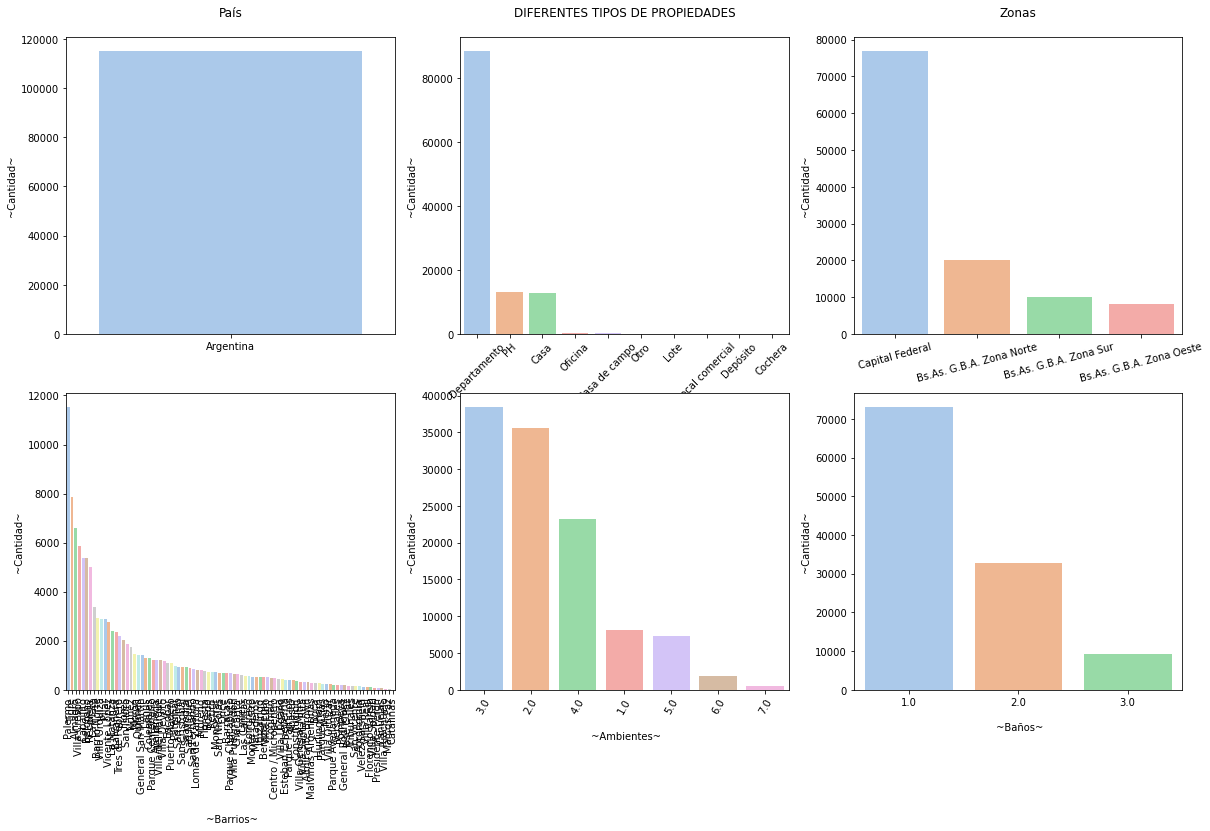

In [25]:
plt.figure(figsize=(20,12))

plt.subplot(2,3,1)
sns.countplot(data = data, x = "l1",order = data['l1'].value_counts().index ,palette="pastel")
plt.title('País\n')                  
plt.xlabel('\n')                           
plt.ylabel('~Cantidad~')                                      

plt.subplot(2,3,2)
sns.countplot(data = data, x = "property_type",order = data['property_type'].value_counts().index ,palette="pastel")
plt.title('DIFERENTES TIPOS DE PROPIEDADES\n')                  
plt.xlabel('\n ~Tipo de Propiedad~')                           
plt.ylabel('~Cantidad~')                                      
plt.xticks(rotation = 45)

plt.subplot(2,3,3)
sns.countplot(data = data, x = "l2",order = data['l2'].value_counts().index ,palette="pastel")
plt.title('Zonas\n')                  
plt.xlabel('\n')                           
plt.ylabel('~Cantidad~')                                      
plt.xticks(rotation = 15) 

plt.subplot(2,3,4)
sns.countplot(data = data, x = "l3",order = data['l3'].value_counts().index ,palette="pastel")                  
plt.xlabel('\n ~Barrios~')                           
plt.ylabel('~Cantidad~')                                      
plt.xticks(rotation = 90) 

plt.subplot(2,3,5)
sns.countplot(data = data, x = "rooms",order = data['rooms'].value_counts().index ,palette="pastel")                
plt.xlabel('\n ~Ambientes~')                           
plt.ylabel('~Cantidad~')                                      
plt.xticks(rotation = 60) 

plt.subplot(2,3,6)
sns.countplot(data = data, x = "bathrooms",order = data['bathrooms'].value_counts().index ,palette="pastel")                 
plt.xlabel('\n ~Baños~')                           
plt.ylabel('~Cantidad~')                                      

plt.show()

#### Observando el grafico, procedo:

    1. Eliminando la columnan País ya que todas las propiedades se encuentran en Argentina.
    2. Agrupando los tipos de propiedades que no sean Departamento, PH o Casa en una cuarta feature ya que no son relevantes en cantidad de datos. 
    3. Opto por quedarme sin los barrios 

### 1.

In [26]:
data = data.drop('l1',1)
data.head(1)

,l2,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,property_type
1,Capital Federal,Boedo,2.0,1.0,2.0,70.0,58.0,159000.0,PH


### 2.

In [27]:
data = data.replace({'Oficina': 'Otro', 'Casa de campo': 'Otro', 'Lote': 'Otro',
                     'Local comercial': 'Otro','Depósito': 'Otro','Cochera': 'Otro'})

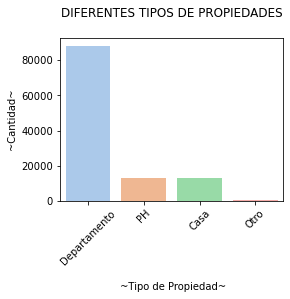

In [28]:
plt.figure(figsize=(4,3))
sns.countplot(data = data, x = "property_type",order = data['property_type'].value_counts().index ,palette="pastel")
plt.title('DIFERENTES TIPOS DE PROPIEDADES\n')                  
plt.xlabel('\n ~Tipo de Propiedad~')                           
plt.ylabel('~Cantidad~')                                      
plt.xticks(rotation = 45)
plt.show()

### 3.

In [29]:
data.shape

(114954, 9)

In [30]:
data = data.drop('l3',1)

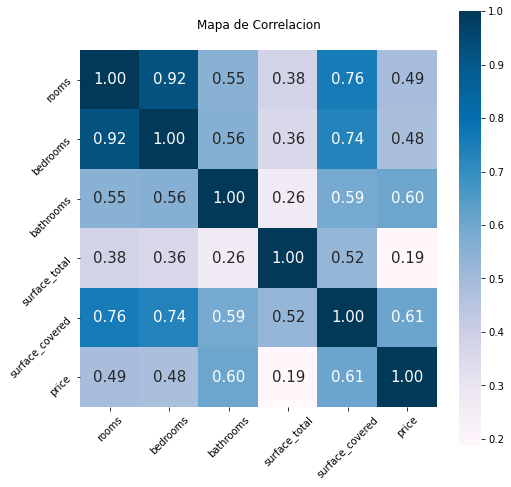

In [31]:
corr = data.corr()

plt.figure(figsize=(8,8))
sns.heatmap(corr, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 15},
             xticklabels= corr.columns.values, 
             yticklabels= corr.columns.values, cmap= 'PuBu')
plt.title('Mapa de Correlacion\n')
plt.xticks(rotation = 45)
plt.yticks(rotation = 45) 
plt.show()

En el mapa vemos las mejores variables que podríamos utilizar para predecir el precio son las más cercanas a 1 en la columna precio, la correlacion con el precio de 'bathrroms' seguido tan solo 0.01 detras por surface_covered son valores aceptables para entrenar.  

### Encoding

Procedo a convertir las variables categoricas a numericas

In [32]:
data.head(1)

,l2,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,property_type
1,Capital Federal,2.0,1.0,2.0,70.0,58.0,159000.0,PH


In [33]:
data = pd.get_dummies( data, columns = ['l2'])
data = pd.get_dummies( data, columns = ['property_type'])

In [34]:
data.head(1)

,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,l2_Bs.As. G.B.A. Zona Norte,l2_Bs.As. G.B.A. Zona Oeste,l2_Bs.As. G.B.A. Zona Sur,l2_Capital Federal,property_type_Casa,property_type_Departamento,property_type_Otro,property_type_PH
1,2.0,1.0,2.0,70.0,58.0,159000.0,0,0,0,1,0,0,0,1


### 4. Escalado de Datos

Con el DataFrame ya preparado para su analisis, procedo a entrenar, escalar y comparar los resultados con los del arbol de desicion del proyecto 1.


In [35]:
#Elijo las mismas variables que el modelo del proyecto 1

X = data[['surface_covered','surface_total','rooms','bedrooms','bathrooms']]
y = data[['price']]

#Preparo los datos para el entrenamiento 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [36]:
#Los escalo despues de Separarlos para no tener datos cruzados

scaler_X = StandardScaler()
scaler_y = StandardScaler() 

X_train = scaler_X.fit_transform(X_train)
y_train = scaler_y.fit_transform(y_train)

X_test = scaler_X.transform(X_test)
y_test = scaler_y.transform(y_test)

In [37]:
print(X_train.shape ,y_train.shape)
print(X_test.shape ,y_test.shape)

(86215, 5) (86215, 1)
(28739, 5) (28739, 1)


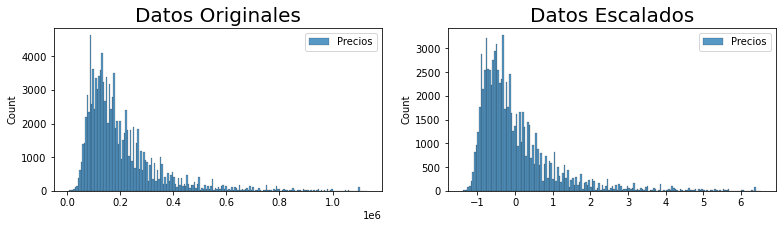

In [38]:
# Analizo si es logico lo que escale

plt.figure(figsize=(20,3))
  
plt.subplot(1,3,1)
sns.histplot(y,color='g',label = 'Precios')
plt.legend()
plt.title('Datos Originales',fontsize = 20)

plt.subplot(1,3,2)
sns.histplot(y_train,color='g',label = 'Precios')
plt.legend()
plt.title('Datos Escalados',fontsize = 20)
plt.show()

Se ve como respecta la campana y los datos extras de precio en el grafico de la derecha son por que a los datos le faltan los valores de y_test.

### El modelo de Árbol de Desición  con (5 variables y 10 de profundidad). 

Valores del Árbol de Decisión del proyecto 1:
* Raíz del error cuadrático medio en Train: 119536.88066366651
* Raíz del error cuadrático medio en Test: 151750.71398058665

In [39]:
Tree = DecisionTreeRegressor(max_depth = 10)
Tree.fit(X_train,y_train)

y_train_Tree = Tree.predict(X_train)
y_test_Tree = Tree.predict(X_test)

In [40]:
# Los invierto solo para obtener valores del RMSE comparables con los del proyecto 1

y_train_Tree = scaler_y.inverse_transform((y_train_Tree))
y_test_Tree = scaler_y.inverse_transform(y_test_Tree)
y_train = scaler_y.inverse_transform(y_train)
y_test = scaler_y.inverse_transform(y_test)


### Metrica a Utilizar

La métrica con la que evaluare el modelo de regresión es la raíz del error cuadrado promedio (RMSE), es sensible a valores atípicos al igual que el error cuadrado promedio (MSE) y puedo trabajar con las mismas unidades y magnitudes que la variable y, no así con el MSE al estas elevado al cuadrado. 

A menor valor de RMSE, mejor es el regresor. En el caso ideal, los errores serán 0.


In [41]:
rmse_train_Tree = np.sqrt(mean_squared_error(y_train, y_train_Tree))
rmse_test_Tree = np.sqrt(mean_squared_error(y_test, y_test_Tree))
print(f'Raíz del error cuadrático medio en Train: {rmse_train_Tree}')
print(f'Raíz del error cuadrático medio en Test: {rmse_test_Tree}')


Error = pd.DataFrame(columns=['Modelo','Train','Test'],index=range(6))
Error.iloc[0,0] = 'Arbol de Desicion Proyecto 1'
Error.iloc[0,1] = 119536.88066366651
Error.iloc[0,2] = 151750.71398058665
Error.iloc[1,0] = 'Arbol de Desicion Preprocesado'
Error.iloc[1,1] = rmse_train_Tree
Error.iloc[1,2] = rmse_test_Tree

Raíz del error cuadrático medio en Train: 85945.14948275994
Raíz del error cuadrático medio en Test: 91176.1506264018


Tenemos a simple vista como con preposesamiento los valores mejoraron notablemente, disminuyendo el overfitting y el error en un 30% del train y un 40% del test. 

### Parte B - Modelos Avanzados


Evaluaremos el desempeño de un modelo de Regresion Lineal con atributos polinomicos, tambien evaluare con XGboost y Random Forest. Primero con sus valores por defecto, luego aplicaremos optimizacion de hiperparametros utilizando random search y grid search. Finalmente compararemos los resultados obtenidos.


Vuelvo a entrenar los datos por que agrego 2 variables mas 'property_type' y 'l2', tambien debo volver a escalar.

In [255]:
X = data.drop(['price'],1)
y = data[['price']]

#Preparo los datos para el entrenamiento 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

#Escalo los datos
scaler_X = StandardScaler()
scaler_y = StandardScaler() 

X_train = scaler_X.fit_transform(X_train)
y_train = scaler_y.fit_transform(y_train)

X_test = scaler_X.transform(X_test)
y_test = scaler_y.transform(y_test)

#### Defino una funcion para evaluar los modelos y sus errores.

In [256]:
def evaluar_modelo(model, X_train, X_test, y_train, y_test):
       
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    y_train_pred = scaler_y.inverse_transform(y_train_pred)
    y_test_pred = scaler_y.inverse_transform(y_test_pred)
    y_train = scaler_y.inverse_transform(y_train)
    y_test = scaler_y.inverse_transform(y_test)
  
    #Le doy forma, por que con los modelos de XGboost y Random Forest no coincidian en la resta
    y_train_pred = y_train_pred.reshape((len(y_train_pred),1))
    y_test_pred = y_test_pred.reshape((len(y_test_pred),1))
    

    ###CALCULAMOS EL ERROR
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    
    print(f'Raíz del error cuadrático medio en Train: {rmse_train}')
    print(f'Raíz del error cuadrático medio en Test: {rmse_test}\n')

    plt.figure(figsize = (8,4))

    plt.subplot(1,2,1)
    sns.distplot(y_train - y_train_pred, bins = 20, label = 'train')
    sns.distplot(y_test - y_test_pred, bins = 20, label = 'test')
    plt.xlabel('errores')
    plt.legend()


    ax = plt.subplot(1,2,2)
    ax.scatter(y_test,y_test_pred, s =2)

    lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes]
    ]

    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    plt.xlabel('y (test)')
    plt.ylabel('y_pred (test)')

    plt.tight_layout()
    plt.show()

In [261]:
gc.collect()

34440

#### Calculo por defecto una Regresion Lineal con atributos polinomicos para comparar.

REGRESIÓN CON ATRIBUTOS POLINÓMICOS NUMERO 2
Agregamos atributos hasta la potencia x**2

Raíz del error cuadrático medio en Train: 78425.98634580694
Raíz del error cuadrático medio en Test: 79198.66351395585



D:\Programas\Ananconda\envs\datascience\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
D:\Programas\Ananconda\envs\datascience\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


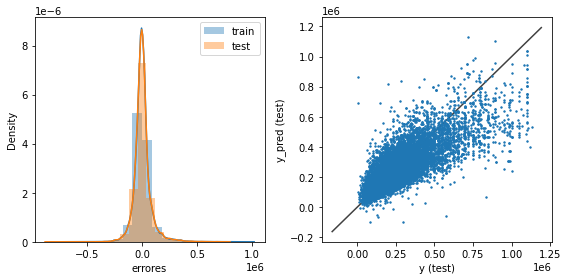

In [258]:
poly = PolynomialFeatures()

X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.fit_transform(X_test)

LR = LinearRegression()
LR.fit(X_train_poly,y_train)

print(f'REGRESIÓN CON ATRIBUTOS POLINÓMICOS NUMERO 2')
print(f'Agregamos atributos hasta la potencia x**2\n')

evaluar_modelo(LR,X_train_poly, X_test_poly, y_train, y_test)

En la gráfica de la izquierda podemos ver los errores de RMSE que representan el error global del regresor que son similares tanto para test como para train.
Los histogramas de los errores son simétricos, aproximadamente gaussianos, y parecidos para ambos conjuntos. Esto es un indicador de que estamos aproximando a nuestros datos de manera correcta.
En la gráfica derecha podemos como los valores presentan una distribucion aproximada.


#### Utilizamos este resultado como Benchmark

### Optimizamos el modelo de Regresión Lineal, evaluo el grado mas conveniente del polinomio.

REGRESIÓN CON ATRIBUTOS POLINÓMICOS NUMERO 1
Agregamos atributos hasta la potencia x**1
Raíz del error cuadrático medio en Train: 89247.79302324519
Raíz del error cuadrático medio en Test: 90115.3963280673



D:\Programas\Ananconda\envs\datascience\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
D:\Programas\Ananconda\envs\datascience\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


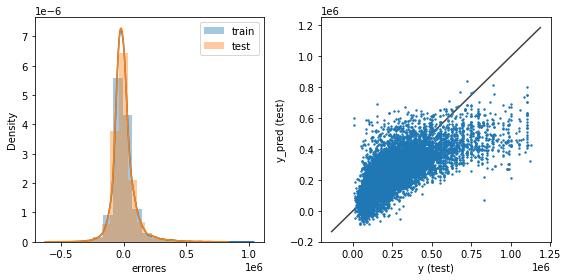



REGRESIÓN CON ATRIBUTOS POLINÓMICOS NUMERO 2
Agregamos atributos hasta la potencia x**2
Raíz del error cuadrático medio en Train: 78425.98634580694
Raíz del error cuadrático medio en Test: 79198.66351395585



D:\Programas\Ananconda\envs\datascience\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
D:\Programas\Ananconda\envs\datascience\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


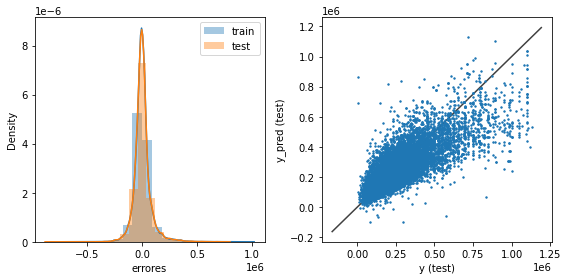



REGRESIÓN CON ATRIBUTOS POLINÓMICOS NUMERO 3
Agregamos atributos hasta la potencia x**3
Raíz del error cuadrático medio en Train: 76467.25943586433
Raíz del error cuadrático medio en Test: 77387.05776068993



D:\Programas\Ananconda\envs\datascience\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
D:\Programas\Ananconda\envs\datascience\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


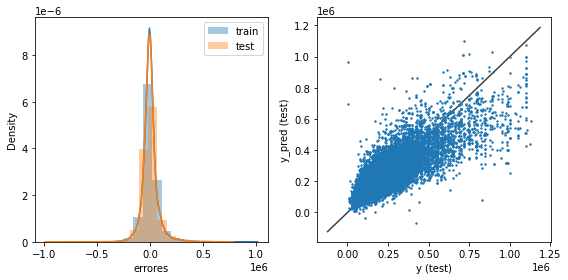

MemoryError: Unable to allocate 1.53 GiB for an array with shape (86215, 2380) and data type float64

In [259]:
for i in range(1,5):
    poly = PolynomialFeatures(degree = i)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.fit_transform(X_test)
    
    LR = LinearRegression()
    LR.fit(X_train_poly,y_train)
    
    print(f'REGRESIÓN CON ATRIBUTOS POLINÓMICOS NUMERO {i}')
    print(f'Agregamos atributos hasta la potencia x**{i}')
    evaluar_modelo(LR,X_train_poly, X_test_poly, y_train, y_test)
    print('\n')

Puedo ver como el atributo polinomico 3 se ajusta mejor a los datos donde veo el valor menor del RMSE, donde hay menor Overfitting y la grafica es la que mejor distribuida esta.

### Aplico Grid Search y Cross Validation

In [262]:
poly = PolynomialFeatures(degree = 3)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.fit_transform(X_test)

Al leer la documentacion el unico parametro que me intereso fue normalize.

In [263]:
para_grid = {'normalize':[False,True]}

In [264]:
LR_GS = GridSearchCV(LR,param_grid = para_grid,cv = 5, scoring = ('neg_root_mean_squared_error'))

In [265]:
LR_GS.fit(X_train_poly,y_train)

GridSearchCV(cv=5, estimator=LinearRegression(),
             param_grid={'normalize': [False, True]},
             scoring='neg_root_mean_squared_error')

In [266]:
print('Mejores Parametros:'+str(LR_GS.best_params_))
print('Mejor Score:'+str(LR_GS.best_score_))

Mejores Parametros:{'normalize': False}
Mejor Score:-0.5511038009787163


REGRESIÓN CON ATRIBUTOS POLINÓMICOS NUMERO 3
Agregamos atributos hasta la potencia x**3
Raíz del error cuadrático medio en Train: 76467.29462624757
Raíz del error cuadrático medio en Test: 77387.140662142



D:\Programas\Ananconda\envs\datascience\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
D:\Programas\Ananconda\envs\datascience\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


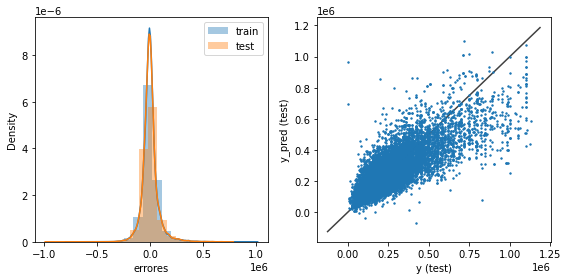

In [267]:
print(f'REGRESIÓN CON ATRIBUTOS POLINÓMICOS NUMERO 3')
print(f'Agregamos atributos hasta la potencia x**3')
evaluar_modelo(LR_GS,X_train_poly, X_test_poly, y_train, y_test)

Observamos nuevamente una buena distribucion en el histograma de la izquierda, los errores de RMSE que representan el error global del regresor que son similares tanto para test como para train.
Comparando con el modelo de Benchmark tenemos una mejora aproximada del RMSE en un 7% en train y un 6% test.

## Realizando las comparaciones con el modelo benchmark

### Ridge

In [324]:
para_grid = {'alpha':np.arange(0.1,10,0.1),'normalize':[False,True]}

reg_ridge = Ridge()

poly = PolynomialFeatures(degree = 3)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

R_GS = GridSearchCV(reg_ridge,param_grid = para_grid,cv = 5,
                    scoring = ('neg_root_mean_squared_error'))

In [270]:
R_GS.fit(X_train_poly,y_train)

GridSearchCV(cv=2, estimator=Ridge(),
             param_grid={'alpha': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6,
       2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9,
       4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. , 5.1, 5.2,
       5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6. , 6.1, 6.2, 6.3, 6.4, 6.5,
       6.6, 6.7, 6.8, 6.9, 7. , 7.1, 7.2, 7.3, 7.4, 7.5, 7.6, 7.7, 7.8,
       7.9, 8. , 8.1, 8.2, 8.3, 8.4, 8.5, 8.6, 8.7, 8.8, 8.9, 9. , 9.1,
       9.2, 9.3, 9.4, 9.5, 9.6, 9.7, 9.8, 9.9]),
                         'normalize': [False, True]},
             scoring='neg_root_mean_squared_error')

In [271]:
print('Mejores Parametros:'+str(R_GS.best_params_))
print('Mejor Score:'+str(R_GS.best_score_))

Mejores Parametros:{'alpha': 9.9, 'normalize': False}
Mejor Score:-0.5534168044161618


In [272]:
R_R = Ridge(alpha = 9.9,normalize=False)
R_R = R_R.fit(X_train_poly,y_train)

Raíz del error cuadrático medio en Train: 76467.29136311832
Raíz del error cuadrático medio en Test: 77387.40626016252



D:\Programas\Ananconda\envs\datascience\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
D:\Programas\Ananconda\envs\datascience\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


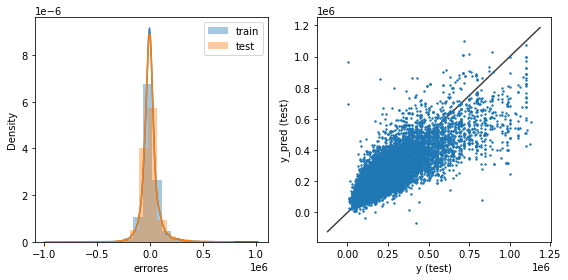

In [273]:
evaluar_modelo(R_R,X_train_poly, X_test_poly, y_train, y_test)

Vemos valores muy similares con respecto al anterior modelo. Es preferible no aplicarlo en este caso ya que es una leve mejoria que no se justifica con el gasto computacional utilizado.

### XGboost

In [303]:
X = data.drop(['price'],1)
y = data[['price']]

#Preparo los datos para el entrenamiento 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

#Escalo los datos
scaler_X = StandardScaler()
scaler_y = StandardScaler() 

X_train = scaler_X.fit_transform(X_train)
y_train = scaler_y.fit_transform(y_train)

X_test = scaler_X.transform(X_test)
y_test = scaler_y.transform(y_test)


In [305]:
Xg = XGBRegressor(booster = 'gbtree', random_state = 42)
Xg.fit(X_train,y_train.ravel())

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

Raíz del error cuadrático medio en Train: 63621.07235657829
Raíz del error cuadrático medio en Test: 69725.13259634595



D:\Programas\Ananconda\envs\datascience\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
D:\Programas\Ananconda\envs\datascience\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


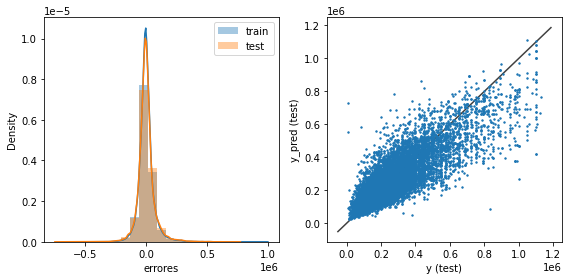

In [308]:
evaluar_modelo(Xg,X_train,X_test,y_train,y_test)

En este modelo por default, se ve un buen resultado respecto a los errores, un poco de overfiting.

In [325]:
XG = XGBRegressor()

para_rand_XG =  {'n_estimators': np.arange(50,100,200),
                'max_depth': [4,5,6],
                 'learning_rate':[0.01,0.15,0.3],
                 'colsample_bytree':[0.8,0.9,1],
                 'reg_alpha':[0,0.1,],
                'reg_lambda':[0.8,1,1.2]
                }

XG_model = RandomizedSearchCV(XG,param_distributions = para_rand_XG,
                             cv = 5, random_state = 42, scoring = ('neg_root_mean_squared_error'))

Los parametros que seleccione en la grilla de Randomized intente que dieran un resultado variado y que no demande tanto tiempo computacional.

In [316]:
XG_model.fit(X_train,y_train.ravel())

RandomizedSearchCV(cv=2,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=100, n...
                                          random_state=None, reg_alpha=None,
                                          reg_lambda=None,
                                          scale_pos_we

In [317]:
print('Mejores Parametros:'+str(XG_model.best_params_))
print('Mejor Score:'+str(XG_model.best_score_))

Mejores Parametros:{'reg_lambda': 1.2, 'reg_alpha': 0, 'n_estimators': 50, 'max_depth': 6, 'learning_rate': 0.3, 'colsample_bytree': 1}
Mejor Score:-0.5107902870858574


Raíz del error cuadrático medio en Train: 67706.55051714167
Raíz del error cuadrático medio en Test: 71774.23984702305



D:\Programas\Ananconda\envs\datascience\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
D:\Programas\Ananconda\envs\datascience\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


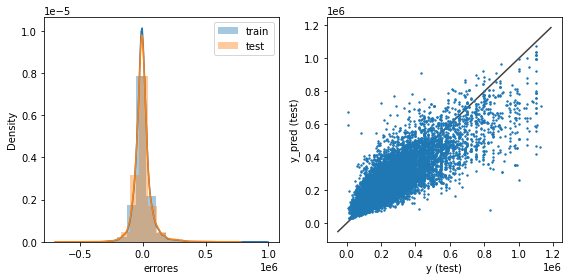

In [318]:
evaluar_modelo(XG_model,X_train,X_test,y_train,y_test)

Luego de optimizar el modelo, vemos como se elevo levemente el error y se redujo el overfitting ajustándose mejor a la solución del problema. El modelo por default obtiene valores del error menores pero su overfitting es mayor así que elijo el modelo que optimizé con RandomizerCV.

### Random Forest


In [319]:
X = data.drop(['price'],1)
y = data[['price']]

#Preparo los datos para el entrenamiento 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

#Escalo los datos
scaler_X = StandardScaler()
scaler_y = StandardScaler() 

X_train = scaler_X.fit_transform(X_train)
y_train = scaler_y.fit_transform(y_train)

X_test = scaler_X.transform(X_test)
y_test = scaler_y.transform(y_test)

In [320]:
Rf = RandomForestRegressor(oob_score = True,random_state = 42)
Rf.fit(X_train, y_train.ravel())

RandomForestRegressor(oob_score=True, random_state=42)

Raíz del error cuadrático medio en Train: 39445.708159717375
Raíz del error cuadrático medio en Test: 62642.501632627005



D:\Programas\Ananconda\envs\datascience\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
D:\Programas\Ananconda\envs\datascience\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


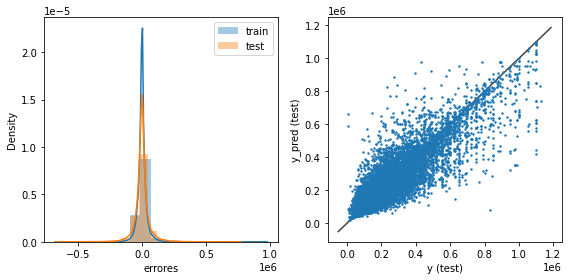

In [321]:
evaluar_modelo(Rf,X_train,X_test,y_train,y_test)

Claramente en el RMSE vemos Overfitting donde hay un bajo error en train y un elevado test con respecto al train.

##### Preparo la grilla para utilizar Randomized Search y ver cuales son los mejores hiperparametros para el Random Forest

In [322]:
# Elijo las variables
rf_rand= {"n_estimators": np.arange(10,100,10),
          "max_depth": range(1,15),
          "min_samples_split": np.arange(2,10,2),
          "min_samples_leaf" : np.arange(1,11,2),
          "max_features": [0.5,1,'sqrt','auto'],
          "max_samples" : [10000]
          }
RF = RandomForestRegressor()
# Prerao el modelo 
RF_rs= RandomizedSearchCV(estimator = RF, param_distributions = rf_rand,
                             n_iter = 100, cv = 5,
                             verbose= True, random_state = 42)

In [323]:
# Lo entreno 
RF_rs.fit(X_train,y_train.ravel())

Fitting 2 folds for each of 100 candidates, totalling 200 fits


RandomizedSearchCV(cv=2, estimator=RandomForestRegressor(), n_iter=100,
                   param_distributions={'max_depth': range(1, 15),
                                        'max_features': [0.5, 1, 'sqrt',
                                                         'auto'],
                                        'max_samples': [10000],
                                        'min_samples_leaf': array([1, 3, 5, 7, 9]),
                                        'min_samples_split': array([2, 4, 6, 8]),
                                        'n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])},
                   random_state=42, verbose=True)

In [110]:
print('Mejores Parametros:'+str(RF_rs.best_params_))
print('Mejor Score:'+str(RF_rs.best_score_))

Mejores Parametros:{'n_estimators': 90, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_samples': 10000, 'max_features': 0.5, 'max_depth': 13}
Mejor Score:0.7466881301218147


Raíz del error cuadrático medio en Train: 67624.95294911419
Raíz del error cuadrático medio en Test: 70897.4160804459



D:\Programas\Ananconda\envs\datascience\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
D:\Programas\Ananconda\envs\datascience\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


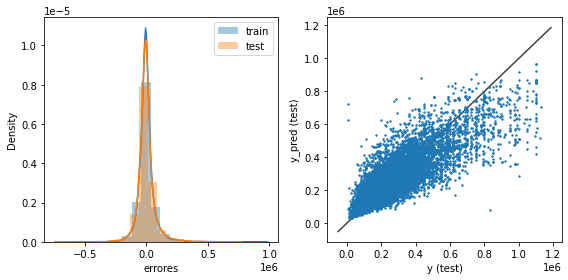

In [327]:
evaluar_modelo(RF_rs,X_train,X_test,y_train,y_test)

Comparado al modelo ejecutado con valores por default vemos que en el modelo con RandomizedCV mejoramos considerablemente el overfitting. El error se elevo levemente, los valores actuales se adaptan mejor a una solucion de compromiso.

### Parte C - Interpretacion de Modelos

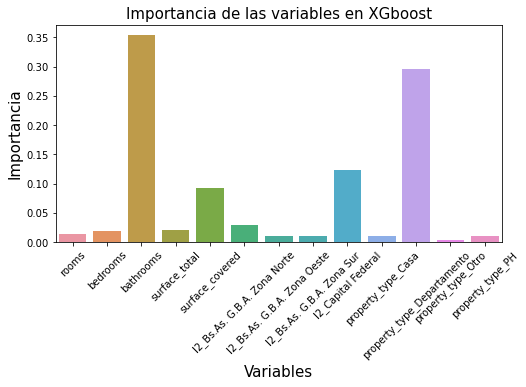

In [332]:
plt.figure(figsize=(8,4))
imp = Xg.feature_importances_
columns = X.columns

sns.barplot(x=columns, y=imp)
plt.title('Importancia de las variables en XGboost',fontsize=15)
plt.xticks(rotation=45)
plt.xlabel('Variables',fontsize=15)
plt.ylabel('Importancia', fontsize=15)
plt.show()

En el modelo XGboost las variables mas importantes fueron 'bathrooms', 'surface_covered' y 'l2_Capital_Federal' respectivamente.


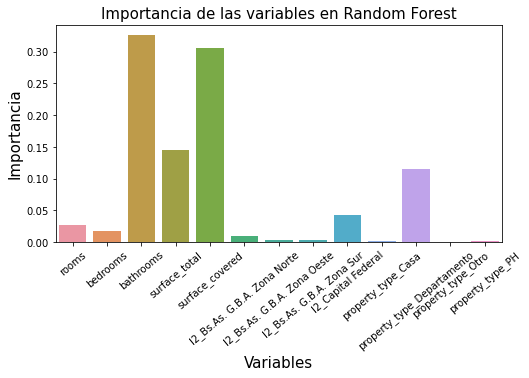

In [334]:
plt.figure(figsize=(8,4))
imp = Rf.feature_importances_
columns = X.columns

sns.barplot(x=columns, y=imp)
plt.title('Importancia de las variables en Random Forest',fontsize=15)
plt.xticks(rotation=40)
plt.xlabel('Variables',fontsize=15)
plt.ylabel('Importancia', fontsize=15)
plt.show()

En el modelo Random Forest las variables mas importantes fueron 'bathrooms', 'surface_covered', 'surface_total' y 'property_type_Casa' respectivamente, responde al mapa de correlacion del dataset.

### Conclusión

Podemos ver cómo han mejorado los modelos con respecto al utilizado en el anterior proyecto como el utilizado al comienzo (Benchmark) con el preprocesado y las modificaciones necesarias dependiendo del modelo.

Los mejores modelos fueron **Random Forest** con RandomizedCV resulto con bajo error y bajo overfitting y el modelo de **XGboost** con RandomizedCV tiene un RMSE (test) "bajo" y un overfitting aceptable. Considero que el overfitting es alto con respecto a los obtenidos en otros modelos y que el modelo podría ajustar mejor.

El modelo de **Regresion Linear** da un muy buen resultado gracias a la utilizacion de PolinomialFeatures ajustandose muy bien con un error bajo y sin overfitting.

Las variables utilizadas parecen lógicas y representativas. Sin embargo, las variables 'rooms', 'bedrooms' y 'surface_total' tienen una baja importancia en el modelo.



### Metodología y Mejoras

Considero que la Metodología utilizada respecto al proyecto 1 fué mucho mas compleja, al utilizar modelos mas avanzados y metodos de Iteración, lo cual demanda mayor conocimiento respecto a lo que utilizamos pero a su vez otorga mayor flexibilidad a la hora de buscar respuestas. 
Para mejorar hay varios puntos, uno de ellos es el sesgo en el precio de las propiedades, tiene una cola hacia la derecha lo que genera que los modelos elijan mas las propiedades de precios moderados sesgando los precios mas elevados. Otro punto a mejorar es la impletacion de GridsearchCV por RandomizedCV, ya que este ultimo elije valores al azar mejorando el tiempo de procesamiento pero varias veces note que la mejor opción era omitida.
En resumen los modelos son ampliamente mejores al proyecto anterior y la optimizacion de hiperparametros quedo demostrado la ayuda que trae. Otro aspecto a destacar fue la velocidad XGboost.